## LSTM AUTOENCODER

In [1]:
# Parts of this code are inspired by 
# GeeksforGeeks (2022): Implementing an Autoencoder in PyTorch. Available online at https://www.geeksforgeeks.org/implementing-an-autoencoder-in-pytorch/, updated on 7/7/2022, checked on 7/16/2024.

In [2]:
import torch
import matplotlib.pyplot as plt
from dataset.cycling_dataset import TorchCyclingDataset
from notebooks.autoencoder.lstm_ae import LSTM_AE

from tqdm import tqdm
from statistics import mean


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\mwenn\PycharmProjects\ComTec-I\venv\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\mwenn\PycharmProjects\ComTec-I\venv\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "C:\Users\mwenn\PycharmProjects\ComTec-I\venv\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io

In [3]:
BATCH_SIZE = 8

In [4]:
def plot(losses):
    # Defining the Plot Style
    plt.style.use('fivethirtyeight')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
     
    # Plotting
    plt.plot(losses)

In [5]:
# Load preprocessed datasets
backwheel_test = TorchCyclingDataset(file_path_acc="../../data/preprocessed/backwheel_acc_test.h5",
                             file_path_gyro="../../data/preprocessed/backwheel_gyro_test.h5")
backwheel_train = TorchCyclingDataset(file_path_acc="../../data/preprocessed/backwheel_acc_train.h5",
                              file_path_gyro="../../data/preprocessed/backwheel_gyro_train.h5")

handlebar_test = TorchCyclingDataset(file_path_acc="../../data/preprocessed/handlebar_acc_test.h5",
                             file_path_gyro="../../data/preprocessed/handlebar_gyro_test.h5")
handlebar_train = TorchCyclingDataset(file_path_acc="../../data/preprocessed/handlebar_acc_train.h5",
                              file_path_gyro="../../data/preprocessed/handlebar_gyro_train.h5")

In [6]:
# DataLoader is used to load the dataset 
# for training
backwheel_test_loader = torch.utils.data.DataLoader(dataset = backwheel_test,
                                     batch_size = BATCH_SIZE,
                                     shuffle = True)
backwheel_train_loader = torch.utils.data.DataLoader(dataset = backwheel_train,
                                     batch_size = BATCH_SIZE,
                                     shuffle = True)

handlebar_test_loader = torch.utils.data.DataLoader(dataset = handlebar_test,
                                     batch_size = BATCH_SIZE,
                                     shuffle = True)
handlebar_train_loader = torch.utils.data.DataLoader(dataset = handlebar_train,
                                     batch_size = BATCH_SIZE,
                                     shuffle = True)

In [7]:
next(iter(handlebar_train_loader))[0].shape

torch.Size([100, 6])

In [8]:
# from https://github.com/shobrook/sequitur/blob/master/sequitur/quick_train.py, 2024-07-20

def train_model(model, train_set, verbose, lr, epochs):
    # model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.MSELoss()

    mean_losses = []
    for epoch in tqdm(range(1, epochs + 1)):
        model.train()

        losses = []
        for batch in train_set:
            for x in batch:
                optimizer.zero_grad()
    
                # Forward pass
                x_prime = model(x)
    
                loss = criterion(x_prime, x)
    
                # Backward pass
                loss.backward()
                optimizer.step()
    
                losses.append(loss.item())

        mean_loss = mean(losses)
        mean_losses.append(mean_loss)

        if verbose:
            print(f"Epoch: {epoch}, Loss: {mean_loss}")
        
        torch.save(model.state_dict(), f'./saved_models/lstm_encoder/lstm_encoder-{epoch:0>{3}}_epoch.pt')
        
        # Plot per epoch
        plot(mean_losses)

    return mean_losses

In [9]:
# Autoencoder model
model = LSTM_AE(input_dim=6,
                  encoding_dim=2,
                  h_dims=[5,3],
                  h_activ=torch.nn.ReLU(),
                  out_activ=torch.nn.Sigmoid(),
                  )

In [10]:
model.encoder

Encoder(
  (layers): ModuleList(
    (0): LSTM(6, 5, batch_first=True)
    (1): LSTM(5, 3, batch_first=True)
    (2): LSTM(3, 2, batch_first=True)
  )
  (h_activ): ReLU()
  (out_activ): Sigmoid()
)

In [11]:
model.decoder

Decoder(
  (layers): ModuleList(
    (0): LSTM(2, 3, batch_first=True)
    (1): LSTM(3, 5, batch_first=True)
    (2): LSTM(5, 5, batch_first=True)
  )
  (h_activ): ReLU()
)

100%|██████████| 100/100 [1:16:41<00:00, 46.01s/it]


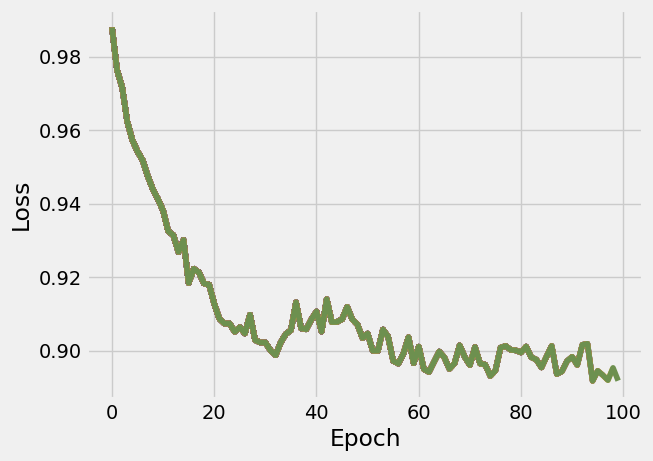

In [12]:
epochs = 100
mean_losses = train_model(model, handlebar_train_loader, verbose=False, lr=1e-3, epochs=epochs)

In [13]:
l_min = float("inf")
for i, l in enumerate(mean_losses):
    if l < l_min:
        l_min = l
    else:
        print(f'Suggested epoch {i}')
        break

Suggested epoch 14


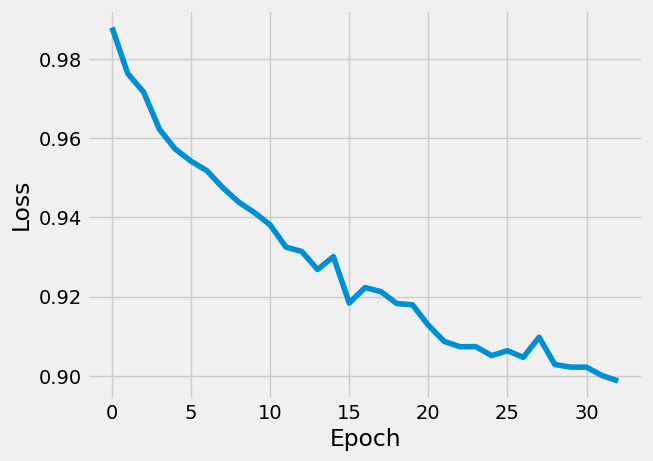

In [19]:
# find max epoch to prevent overfitting
plot(mean_losses[:33])